# ComSeg usage

[ComSeg](https://github.com/fish-quant/ComSeg)  is a transcript-based segmentation method that creates a KNN graph of RNA molecules, weighted by the co-expression of RNA species. Initially, this KNN graph is partitioned into communities of RNAs likely to belong to the same cell. ComSeg then merges these RNA communities to compute the final cell segmentation. The method uses nucleus segmentation as prior to initialize the partitioning of the KNN graph of RNA molecules.  
ComSeg only segments cells with their nuclei segmented and does not take into account cells without missing nucleus.  

If nucleus segmentation is not available, ComSeg can operate using  other staining segmentation or solely nucleus centroids obtained from other sources. For more details, please refer to the [ComSeg documentation](https://comseg.readthedocs.io/en/latest/).

## Requirements

To use ComSeg, run `pip install comseg` in the same environment as `sopa`. For more installation options, refer to their [installation guide](https://comseg.readthedocs.io/en/latest/installation_guide.html).

Then, choose one the the three use cases (i.e., Snakemake or CLI or API) below.

## Snakemake usage
You can run ComSeg with snakemake in a similar way than the other methods. You can run the toy dataset as follow:

```sh
snakemake --config sdata_path=tuto.zarr --configfile=config/toy/uniform_comseg.yaml --cores 1 --use-conda
```

See [here](https://github.com/gustaveroussy/sopa/tree/master/workflow/config) for MERSCOPE/Xenium/CosMX config files.

## CLI usage

First, follow the original [CLI tutorial](https://gustaveroussy.github.io/sopa/tutorials/cli_usage/) until you finished the "Cellpose segmentation" section, and then, continue below.

####  1. Save a ComSeg config file as a config.json file

We display below a minimal example of a ComSeg `config.json` file

```json
{
    "dict_scale": {
        "x": 1,
        "y": 1,
        "z": 1
    },
    "mean_cell_diameter": 15,
    "max_cell_radius": 20,
    "allow_disconnected_polygon" : true,
    "alpha": 0.5,
    "min_rna_per_cell": 5,
    "gene_column": "genes",
    "norm_vector": false
}
```


If you did not install the needed external R packages, set ```"norm_vector": false```. More information on the parameters can be found in the [ComSeg documentation](https://comseg.readthedocs.io/en/latest/userguide/Minimal_example.html).

#### 2. Create the ComSeg patches
On the toy dataset, this will generate 4 patches.
```
sopa patchify comseg tuto.zarr --config-path config.json --patch-width-microns 200 --patch-overlap-microns 50
```
The shapes-key argument is the name of the nuclei boundaries shape in the sdata object that will be used for the prior and centroid. In this example, it is set to `cellpose_boundaries`, which assumes that the Cellpose segmentation has already been run.

#### 3. Run ComSeg 

- On a specific patch (do that for all `<PATCH_INDEX>`, i.e. from 0 to 3 for this tutorial):
```sopa segmentation comseg tuto.zarr --patch-index <PATCH_INDEX>```
- Or sequentially on all the patches:
```sopa segmentation comseg tuto.zarr```

!!! tip
    Manually running the commands above can involve using many consecutive commands, so we recommend automatizing it. For instance, this can be done using Snakemake or Nextflow. This will help you parallelize it since you can run each task on separate jobs or using multithreading. You can also see how we do it in the [Sopa Snakemake pipeline](https://github.com/gustaveroussy/sopa/blob/master/workflow/Snakefile).

#### 3. Merge the results 

```sopa resolve comseg tuto.zarr --gene-column genes```

#### 4. Finish with the standard CLI commands

You can finish as in the original [CLI tutorial](https://gustaveroussy.github.io/sopa/tutorials/cli_usage/).

E.g., you can run:

```sopa aggregate tuto.zarr --gene-column genes --average-intensities --min-transcripts 10```

```sopa annotate fluorescence tuto.zarr --marker-cell-dict '{"CK": "Tumoral cell", "CD3": "T cell", "CD20": "B cell"}'```

```sopa explorer write tuto.zarr --gene-column genes```

## API usage

In this tutorial, we first compute the nucleus segmentation prior using Cellpose on the DAPI staining


In [1]:
import sopa
import sopa.io
import sopa.segmentation
from sopa.segmentation.transcripts import resolve
from sopa.segmentation.methods import comseg_patch

### 1. Running Cellpose as a prior

First, we generate the bounding boxes of the patches on which Cellpose will be run. Here, the patches have a width and height of 1500 pixels and an overlap of 50 pixels. We advise bigger sizes for real datasets (see our default parameters in one of our config files). On the toy dataset, this will generate 4 patches.

In [2]:
image_key = "image"
points_key = "transcripts"
gene_column = "genes"

### Load the data
sdata = sopa.io.uniform()  # here, we use the toy dataset

patches = sopa.segmentation.Patches2D(sdata, image_key, patch_width=1200, patch_overlap=50)
patches.write()

channels = ["DAPI"]
method = sopa.segmentation.methods.cellpose_patch(
    diameter=35, channels=channels, flow_threshold=2, cellprob_threshold=-6
)
segmentation = sopa.segmentation.StainingSegmentation(sdata, method, channels, min_area=2500)

# The cellpose boundaries will be temporary saved here. You can choose a different path
cellpose_temp_dir = "tuto.zarr/.sopa_cache/cellpose"
segmentation.write_patches_cells(cellpose_temp_dir)

cells = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_temp_dir)
cells = sopa.segmentation.shapes.solve_conflicts(cells)

shapes_key = "cellpose_boundaries"  # name of the key given to the cells in sdata.shapes
sopa.segmentation.StainingSegmentation.add_shapes(sdata, cells, image_key, shapes_key)

[INFO] (sopa.utils.data) Image of size ((4, 2048, 2048)) with 400 cells and 100 transcripts per cell
[INFO] (sopa.patches.patches) 4 patches were saved in sdata['sopa_patches']
[WARNING] (sopa.segmentation.stainings) Running segmentation in a sequential manner. This is not recommended on large images because it can be extremely slow (see https://github.com/gustaveroussy/sopa/discussions/36 for more details)
Reading patches: 100%|██████████| 4/4 [00:00<00:00, 78.56it/s]
[INFO] (sopa.segmentation.stainings) Found 388 total cells
Resolving conflicts: 100%|██████████| 68/68 [00:00<00:00, 9159.63it/s]
[INFO] (sopa.segmentation.stainings) Added 367 cell boundaries in sdata['cellpose_boundaries']


### 2. Generating Patches for ComSeg

Once the nuclei are segmented, we generate the bounding boxes of the patches on which ComSeg will be run. ComSeg also requires the nuclei centroids from the Cellpose segmentation, which are computed using the ```patchify_centroids()```. In this example, the patches have a width and height of 200 microns with an overlap of 50 microns. For real datasets, we recommend using larger patch sizes, up to 8000 microns, depending on cell density. On the toy dataset, this configuration will generate 4 patches.

Note that the patch_width parameter of ```Patches2D()``` is specified in microns, not pixels, as it refers to the coordinate system of the transcripts in sdata, which is in microns.

In [3]:
temp_dir = "tuto.zarr/.sopa_cache/comseg"

patches = sopa.segmentation.Patches2D(sdata, points_key, patch_width=200, patch_overlap=50)

valid_indices = patches.patchify_transcripts(
    temp_dir, use_prior=True, min_transcripts_per_patch=1000
)
valid_indices_centroid = patches.patchify_centroids(temp_dir, min_cells_per_patch=1)
valid_indices = list(set(valid_indices_centroid).intersection(set(valid_indices)))

[INFO] (sopa.patches.patches) Writing sub-CSV for transcript segmentation


[########################################] | 100% Completed | 350.58 ms


[INFO] (sopa.patches.patches) Patches saved in directory tuto.zarr/.sopa_cache/comseg
[INFO] (sopa.patches.patches) Writing sub-CSV for transcript segmentation
[INFO] (sopa.patches.patches) Patches saved in directory tuto.zarr/.sopa_cache/comseg


### 3. Running ComSeg on each patch

Parameters for ComSeg can be gathered into a single configuration dictionary. Below is a simple configuration example for using ComSeg. For a more comprehensive description of the configuration dictionary, please refer to the [documentation](https://comseg.readthedocs.io/en/latest/userguide/Minimal_example.html#Comprensive-description-of-configuration-dictionnary)

Of note, ComSeg segments cells as a point cloud of RNA. To generate cell shapes from the segmented RNA point clouds, ComSeg leverages alpha shapes. An important parameter to set is ```alpha```, which influences the shape of the generated cell polygons. More about `alpha` shapes can be found [here](https://en.wikipedia.org/wiki/Alpha_shape)

In [ ]:
config = {
    "dict_scale": {"x": 1, "y": 1, "z": 1},  # spot coordinates already in µm
    "mean_cell_diameter": 15,
    "max_cell_radius": 25,
    "norm_vector": False,
    "alpha": 0.5,  # alpha value to compute the polygon https://pypi.org/project/alphashape/
    "allow_disconnected_polygon": False,
    "min_rna_per_cell": 5,  # minimal number of RNAs for a cell to be taken into account
    "gene_column": "genes",
}

for patch_index in valid_indices:
    comseg_patch(temp_dir, patch_index, config)

### 4. Resolve segmentation and aggregate
Now, we need to resolve the conflict, i.e. where boundaries of segmented cells are overlapping due to segmentation on multiple patches.  
Then, in the aggregation step, transcripts inside each cell are counted and added in a ```AnnData``` object in 
```sdata.tables["table"]```

In [14]:
shapes_key = "comseg_boundaries"

resolve(sdata, temp_dir, gene_column, min_area=10, shapes_key=shapes_key)

aggregator = sopa.segmentation.Aggregator(sdata, image_key=image_key, shapes_key=shapes_key)
aggregator.compute_table(gene_column=gene_column, average_intensities=True)

[INFO] (sopa.segmentation.transcripts) Cells whose area is less than 10 microns^2 will be removed
Resolving conflicts: 100%|██████████| 534/534 [00:00<00:00, 8223.37it/s]
[INFO] (sopa.segmentation.transcripts) Aggregating transcripts on merged cells
[INFO] (sopa.segmentation.aggregate) Aggregating transcripts over 155 cells


[########################################] | 100% Completed | 397.50 ms


[INFO] (sopa.segmentation.transcripts) Added sdata.tables['table'], and 367 cell boundaries to sdata['comseg_boundaries']
[INFO] (sopa.segmentation.aggregate) Using existing table for aggregation
[WARNING] (sopa.segmentation.aggregate) sdata.table is already existing. Transcripts are not count again.
[INFO] (sopa.segmentation.aggregate) Averaging channels intensity over 367 cells with expansion 0.0


[########################################] | 100% Completed | 101.41 ms


/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/spatialdata/_core/_elements.py:92: UserWarning: Key `comseg_boundaries` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/spatialdata/_core/_elements.py:112: UserWarning: Key `table` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)


### 5. Check the segmentation

In [15]:
import spatialdata_plot

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/spatialdata/_core/_elements.py:102: UserWarning: Key `transcripts` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/spatialdata_plot/pl/render.py:320: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = ax.scatter(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


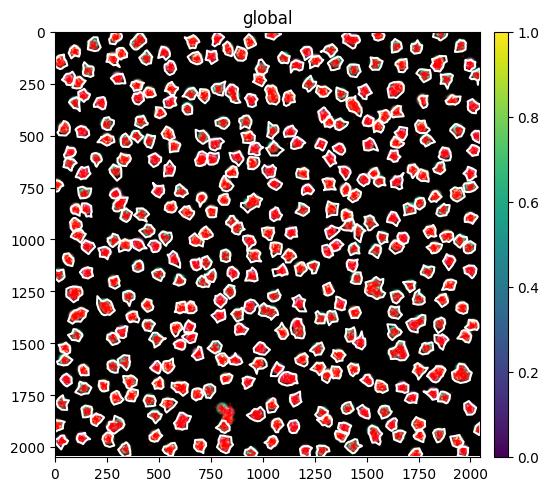

In [16]:
sdata\
    .pl.render_points(size=0.01, color="r")\
    .pl.render_images()\
    .pl.render_shapes(shapes_key, outline=True, fill_alpha=0, outline_color="w")\
    .pl.show("global")

You can also use the Xenium Explorer:

In [12]:
sopa.io.write("tuto.explorer", sdata, image_key, points_key="transcripts", gene_column=gene_column, shapes_key="comseg_boundaries")

[INFO] (sopa.io.explorer.table) Writing table with 5 columns
[INFO] (sopa.io.explorer.table) Writing 2 cell categories: region, slide
[INFO] (sopa.io.explorer.shapes) Writing 367 cell polygons
[INFO] (sopa.io.explorer.points) Writing 40000 transcripts
[INFO] (sopa.io.explorer.points)    > Level 0: 40000 transcripts
[INFO] (sopa.io.explorer.points)    > Level 1: 10000 transcripts
[INFO] (sopa.io.explorer.images) Writing multiscale image with procedure=semi-lazy (load in memory when possible)
[INFO] (sopa.io.explorer.images)    (Loading image of shape (4, 2048, 2048)) in memory
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 2048, 2048)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 1024, 1024)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 512, 512)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 256, 256)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 128, 128)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 64, 64)
[INFO] (sopa.